In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/nlp/

/content/drive/MyDrive/Colab Notebooks/nlp


In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset

In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
my_pal = ['1f77b4', 'ff8c1a', '2ca02c', 'd62728', '9467bd', 'c5b300', 'e377c2', '17becf']
my_pal = [f"#{c}" for c in my_pal]

sns.reset_defaults() # useful when adjusting style a lot
plt.rcParams['font.family']=['sans-serif']
sns.set_theme(context="paper", style="ticks",
              # palette="Set2",
              palette=my_pal,
              rc={
              "pdf.fonttype": 42,  # embed font in output
              "svg.fonttype": "none",  # embed font in output
              "figure.facecolor": "white",
              "figure.dpi": 150,
              "axes.facecolor": "None",
              "axes.spines.left": True,
              "axes.spines.bottom": True,
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

In [ ]:
train = pd.read_csv('subtask1/train/swa.csv')
test = pd.read_csv('subtask1/dev/swa.csv')

train, val = train_test_split(
    train,
    test_size=0.2,
    stratify=train['polarization']
)

train.head()

,id,text,polarization
2166,swa_89e0026527bc80f47be23c837747c825,wawawa uchunge muislamu Nyakundi asije akakuja...,1
6555,swa_a758cb209ceabc8fc986915714ad3ff9,Wajaluo pekee yao ndio wanresist- Murkomen,0
6270,swa_61c13d1836cf78d394f1bd5cc43b7393,KIKUYUS AND KALES MAKING NOISE HAPA NA KWA NYU...,1
693,swa_aa8b336e04c59f80cbf0b1334ac234e3,hawa wakale smh kwani mmepsychia aje olympics ...,1
4136,swa_a64723b282742ed4ae78cb2494233250,mayut let s choos peac mimi na wew election bi...,0


In [ ]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')


    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item



In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('Davlan/afro-xlmr-base')#bert-base-uncased cardiffnlp/twitter-roberta-base-sentiment-latest

# Create datasets
train_dataset = PolarizationDataset(train['text'].tolist(), train['polarization'].tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val['polarization'].tolist(), tokenizer)
test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Models

- Davlan/afro-xlmr-base for swhaili
- xlr-roberta for amharic
- cardiffnlp/twitter-roberta-base-sentiment-latest for english

In [ ]:
# Load the model
# cardiffnlp/twitter-roberta-base-hate-multiclass-latest
# metabloit/swahBERT
# microsoft/deberta-v3-base
# Davlan/afro-xlmr-base
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base
model = AutoModelForSequenceClassification.from_pretrained('Davlan/afro-xlmr-base', num_labels=2,ignore_mismatched_sizes=True)#, num_labels=2,    ignore_mismatched_sizes=True

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

training_args = TrainingArguments(
        output_dir=f"/content/outputs/",
        num_train_epochs=5,
        learning_rate=3e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=1000,
        disable_tqdm=False,
        metric_for_best_model="f1_macro",
        load_best_model_at_end=False,
        greater_is_better=True,
        save_total_limit=1
    )


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()
log_history = trainer.state.log_history
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.465199,0.766668
2,No log,0.464474,0.780530
3,No log,0.460917,0.785358
4,No log,0.483318,0.781270
5,No log,0.497779,0.787702


Macro F1 score on validation set: 0.7877015989965077


In [ ]:
import os
import zipfile

predictions = trainer.predict(test_dataset)


predicted_labels = predictions.predictions.argmax(-1)


results_df = pd.DataFrame({
    'id': test['id'],
    'polarization': predicted_labels
})


os.makedirs('subtask_1', exist_ok=True)


csv_path = 'subtask_1/pred_swa.csv'
results_df.to_csv(csv_path, index=False)

print(f"Saved predictions to {csv_path}")
print(results_df.head())

zip_filename = 'subtask_1_swa_afroxlmr.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('subtask_1'):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.join(os.path.basename(root), file)
            zipf.write(file_path, arcname)

print(f"Created compressed file: {zip_filename}")

Saved predictions to subtask_1/pred_swa.csv
                                     id  polarization
0  swa_a5748df181277341143f7da4175add4a             1
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d             1
2  swa_3718757514005767302b7220b08e409d             1
3  swa_9fa3337a35cce723d60c06056d422330             1
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0             1
Created compressed file: subtask_1_swa_afroxlmr.zip


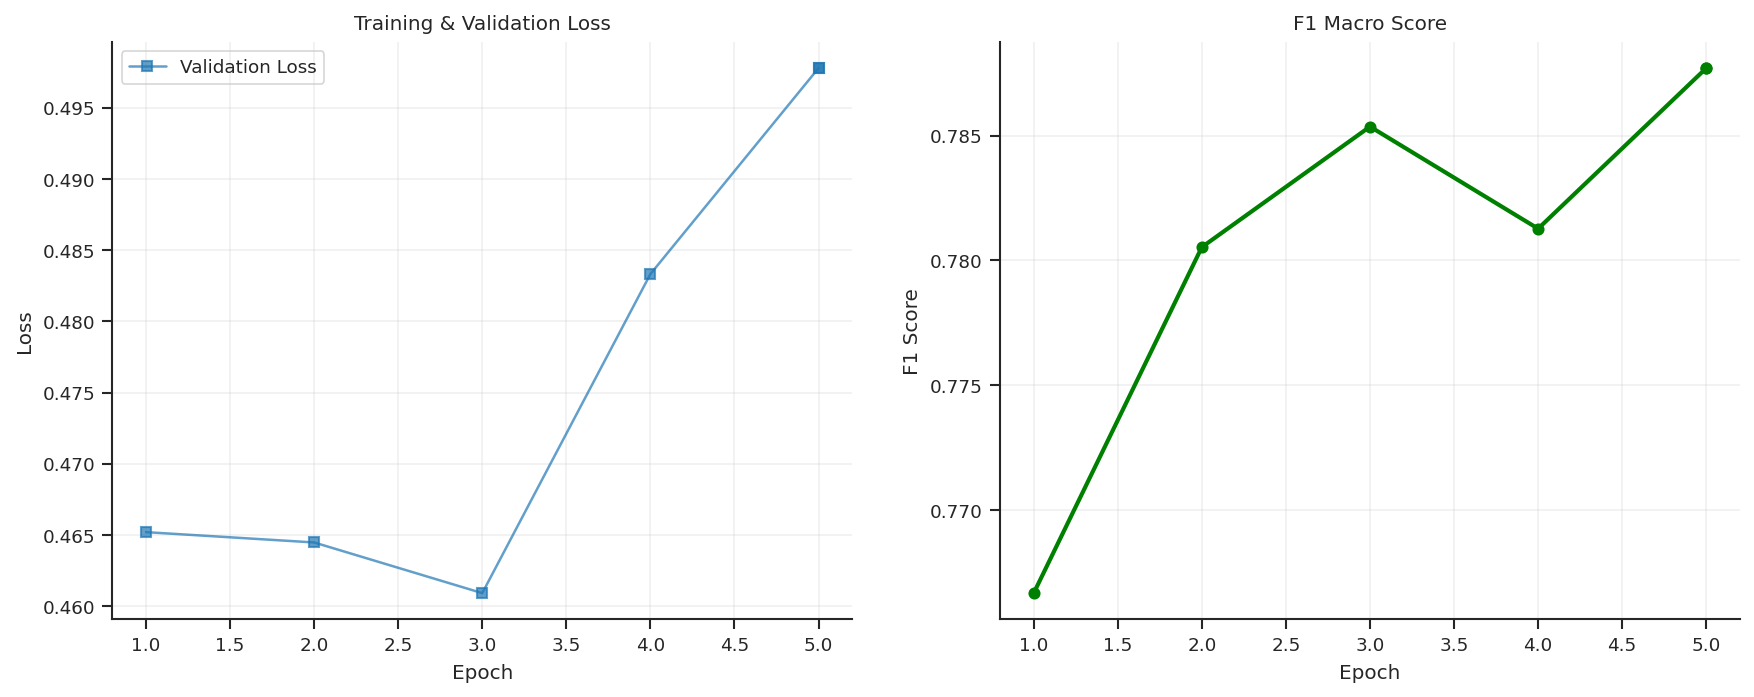

In [ ]:

logs_df = pd.DataFrame(log_history)
# print(logs_df)


# train_logs = logs_df[logs_df['loss'].notna()]
eval_logs = logs_df[logs_df['eval_loss'].notna()]


fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# axes[0].plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', marker='o', alpha=0.7)
axes[0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Macro Score')
axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('single_train_subtask1_swa_afroxlmr',dpi=200,format='pdf' )
plt.show()

In [ ]:
#saving single_models
trainer.save_model('swa_model')

#loading pretrained model
model = AutoModelForSequenceClassification.from_pretrained('swa_model')

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained('swa_model')

task 1 full thing test


In [ ]:

CONFIG = {
    'english': {#cardiffnlp/twitter-roberta-base-hate-latest
        'model_name': 'cardiffnlp/twitter-roberta-base-hate-latest',
        'train_file': 'subtask1/train/eng.csv',
        'test_file': 'subtask1/dev/eng.csv',
        'output_name': 'eng'
    }, #Davlan/afro-xlmr-base
    'swahili': {
        'model_name': 'Davlan/afro-xlmr-base',
        'train_file': 'subtask1/train/swa.csv',
        'test_file': 'subtask1/dev/swa.csv',
        'output_name': 'swa'
    }
}
# Select language
LANGUAGE = 'english'
config = CONFIG[LANGUAGE]

In [ ]:
# @title

import os
import zipfile
import json

#dataset creation
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

#combined metric trainer
class CombinedMetricTrainer(Trainer):
    """
    Custom Trainer that optimizes for both F1 score and loss reduction
    """
    def __init__(self, *args, f1_weight=0.7, loss_weight=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.f1_weight = f1_weight
        self.loss_weight = loss_weight
        self.train_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Track training loss"""
        outputs = model(**inputs)
        loss = outputs.loss

        self.train_losses.append(loss.item())

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Add combined score metric"""
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)


        f1 = metrics.get(f'{metric_key_prefix}_f1_macro', 0)
        loss = metrics.get(f'{metric_key_prefix}_loss', 0)


        normalized_loss = min(loss / 2.0, 1.0)
        combined_score = (self.f1_weight * f1) - (self.loss_weight * normalized_loss)

        metrics[f'{metric_key_prefix}_combined_score'] = combined_score

        if self.train_losses:
            avg_train_loss = np.mean(self.train_losses[-100:])
            metrics[f'{metric_key_prefix}_train_loss_recent'] = avg_train_loss

        return metrics

#enhanced monitoring
class EnhancedMonitoringCallback(TrainerCallback):
    """
    Callback to monitor and log F1, train loss, and eval loss
    """
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_combined = -float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'combined_score': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Log training metrics"""
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Track evaluation metrics"""
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0))
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)
            combined_score = metrics.get('eval_combined_score', 0)


            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)
            self.history['combined_score'].append(combined_score)

            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
            if combined_score > self.best_combined:
                self.best_combined = combined_score


            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")
            print(f"  Combined Score:  {combined_score:.4f} (Best: {self.best_combined:.4f})")


            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            if combined_score == self.best_combined:
                print(f"  ✓ NEW BEST COMBINED SCORE!")
            print(f"{'='*70}\n")

#early stopping
class CombinedEarlyStoppingCallback(TrainerCallback):
    """
    Early stopping based on combined F1 and loss metric
    """
    def __init__(self, patience=5):
        self.patience = patience
        self.best_combined_score = -float('inf')
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            combined_score = metrics.get('eval_combined_score', -float('inf'))

            if combined_score > self.best_combined_score:
                self.best_combined_score = combined_score
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                print(f"\n⚠ Early stopping triggered after {self.patience} epochs without improvement")
                print(f"Best combined score: {self.best_combined_score:.4f}")
                control.should_training_stop = True


#plotting
def plot_all_folds(fold_models, model_name, language):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt

    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    # Left plot: Losses for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title(f'Training & Validation Loss - {short_model_name}', fontsize=12, fontweight='bold')
    axes['losses'].legend(fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    # Right plot: F1 scores for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title(f'F1 Macro Score - {short_model_name}', fontsize=12, fontweight='bold')
    axes['f1'].legend(fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plot_filename = f'subtask1_{cfg["output_name"]}_{short_model_name}.pdf'
    plt.savefig(plot_filename, dpi=200, format='pdf')
    print(f"\n✓ Plot saved to: {plot_filename}")
    plt.show()

    return plot_filename

def save_fold_models(fold_models, fold_metrics, language, plot_filename=None):
    """Save all fold models and metrics in a single compressed file"""
    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    temp_dir = f"/content/temp_models_{cfg['output_name']}"
    os.makedirs(temp_dir, exist_ok=True)

    # Save best model
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]

    best_model_dir = os.path.join(temp_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)
    best_fold_model['model'].save_pretrained(best_model_dir)
    best_fold_model['tokenizer'].save_pretrained(best_model_dir)

    print(f"\n✓ Best model prepared (Fold {best_fold_model['fold']})")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")

    for fold_model in fold_models:
        fold_dir = os.path.join(temp_dir, f"fold_{fold_model['fold']}")
        os.makedirs(fold_dir, exist_ok=True)
        fold_model['model'].save_pretrained(fold_dir)
        fold_model['tokenizer'].save_pretrained(fold_dir)
        print(f"✓ Prepared Fold {fold_model['fold']}")

    # Save metrics
    metrics_path = os.path.join(temp_dir, "fold_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    # Save model info
    model_info = {
        'language': language,
        'model_name': cfg['model_name'],
        'short_model_name': short_model_name,
        'best_fold': best_fold_model['fold'],
        'best_f1': best_fold_model['score'],
        'best_combined_score': best_fold_model['combined_score'],
        'n_folds': len(fold_models)
    }
    info_path = os.path.join(temp_dir, "model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    # Copy plot file to temp directory if provided
    if plot_filename and os.path.exists(plot_filename):
        import shutil
        plot_dest = os.path.join(temp_dir, os.path.basename(plot_filename))
        shutil.copy2(plot_filename, plot_dest)
        print(f"✓ Plot included in model package")

    # Compress everything
    zip_filename = f"subtask1_{cfg['output_name']}_{short_model_name}.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    print(f"\nCompressing all models...")
    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    # Clean up temp directory
    import shutil
    shutil.rmtree(temp_dir)

    print(f"\n{'='*70}")
    print(f"✓ All models saved to compressed file:")
    print(f"  {final_path}")
    print(f"  Model: {short_model_name}")
    print(f"  Language: {language}")
    print(f"{'='*70}\n")

def train_kfold_cv(train_df, model_name, n_splits=5, seed=42):
    """
    Train model using K-Fold Cross-Validation with focus on F1 and loss reduction
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Optimization: Maximize F1 + Minimize Loss")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['polarization'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        # Split data
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = PolarizationDataset(
            train_fold['text'].tolist(),
            train_fold['polarization'].tolist(),
            tokenizer
        )
        val_dataset = PolarizationDataset(
            val_fold['text'].tolist(),
            val_fold['polarization'].tolist(),
            tokenizer
        )

        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,ignore_mismatched_sizes=True
        )

        # Enhanced training arguments
        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,

            # Learning rate optimization
            learning_rate=2e-5,
            lr_scheduler_type="linear",
            warmup_ratio=0.15,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=2,

            weight_decay=0.01,
            max_grad_norm=1.0,
            label_smoothing_factor=0.1,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=25,
            save_total_limit=2,

            load_best_model_at_end=True,
            metric_for_best_model="combined_score",
            greater_is_better=True,

            fp16=True,
            dataloader_num_workers=2,

            disable_tqdm=False,
            report_to="none"
        )

        def compute_metrics(p):
            preds = np.argmax(p.predictions, axis=1)
            f1 = f1_score(p.label_ids, preds, average='macro')
            return {'f1_macro': f1}

        monitoring_callback = EnhancedMonitoringCallback()
        early_stopping_callback = CombinedEarlyStoppingCallback(patience=5)

        trainer = CombinedMetricTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback, early_stopping_callback],
            f1_weight=0.7,
            loss_weight=0.3
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()

        # Final evaluation
        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']
        fold_combined = eval_results['eval_combined_score']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"  Combined Score: {fold_combined:.4f}")
        print(f"  Best F1:        {monitoring_callback.best_f1:.4f}")
        print(f"  Best Eval Loss: {monitoring_callback.best_eval_loss:.4f}")
        print(f"  Best Train Loss:{monitoring_callback.best_train_loss:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'fold': fold + 1,
            'history': monitoring_callback.history
        })

    # Print comprehensive summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"\n  Best Fold:     {np.argmax(fold_scores) + 1} (F1 = {max(fold_scores):.4f})")
    print(f"  Lowest Loss:   {np.argmin([m['eval_loss'] for m in fold_metrics]) + 1} (Loss = {min([m['eval_loss'] for m in fold_metrics]):.4f})")
    print(f"{'='*70}\n")

    # Plot results
    plot_filename = plot_all_folds(fold_models, model_name, LANGUAGE)

    return fold_models, fold_metrics, plot_filename

def ensemble_predict(fold_models, test_dataset, method='weighted'):
    """
    Make predictions using ensemble with optional weighting by performance

    Args:
        method: 'average', 'weighted' (by F1), or 'weighted_combined' (by combined score)
    """
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f}, Loss: {fold_model['eval_loss']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
        all_predictions.append(probs.numpy())

        # Calculate weight based on method
        if method == 'weighted':
            weights.append(fold_model['score'])
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])
        else:
            weights.append(1.0)
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    final_predictions = np.argmax(weighted_probs, axis=1)

    return final_predictions

# ============================================
# LOAD SAVED MODEL FOR PREDICTION
# ============================================
def load_saved_model(language='english', model_name=None):
    """
    Load the best saved model from compressed file

    Args:
        language: 'english', 'swahili', or 'amharic'
        model_name: Optional specific model name

    Returns:
        model, tokenizer, model_info
    """
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask1_{cfg['output_name']}_{short_model_name}.zip"

    print(f"Loading model from: {zip_path}")

    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    best_model_dir = os.path.join(temp_extract_dir, "best_model")
    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

    print(f"✓ Model loaded successfully!")
    print(f"  Model: {model_info['short_model_name']}")
    print(f"  Best Fold: {model_info['best_fold']}")
    print(f"  F1 Score: {model_info['best_f1']:.4f}")

    return model, tokenizer, model_info

def load_all_fold_models(language='english', model_name=None):
    """Load all saved fold models from compressed file for ensemble prediction"""
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/subtask1_{cfg['output_name']}_{short_model_name}.zip"

    print(f"\nLoading all fold models from: {zip_path}")

    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    with open(os.path.join(temp_extract_dir, "fold_metrics.json"), 'r') as f:
        fold_metrics = json.load(f)

    n_folds = model_info['n_folds']
    fold_models = []

    print(f"Loading {n_folds} fold models for {language} ({short_model_name})...")

    for fold_num in range(1, n_folds + 1):
        fold_dir = os.path.join(temp_extract_dir, f"fold_{fold_num}")

        print(f"  Loading Fold {fold_num}...")

        model = AutoModelForSequenceClassification.from_pretrained(fold_dir)
        tokenizer = AutoTokenizer.from_pretrained(fold_dir)

        fold_metric = fold_metrics[fold_num - 1]

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': fold_metric['f1'],
            'eval_loss': fold_metric['eval_loss'],
            'combined_score': fold_metric['combined_score']
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {fold_metric['f1']:.4f}, Loss: {fold_metric['eval_loss']:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models

def predict_with_saved_model(test_csv_path, language='english', model_name=None,
                             output_csv='predictions.csv'):
    """
    Make predictions using a saved model

    Args:
        test_csv_path: Path to test CSV file
        language: 'english', 'swahili', or 'amharic'
        model_name: Optional specific model name
        output_csv: Output CSV filename
    """
    model, tokenizer, model_info = load_saved_model(language, model_name)

    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)
    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(-1)

    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': predicted_labels
    })

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    return results_df

def ensemble_predict_with_saved_models(test_csv_path, language='english', model_name=None,
                                       method='weighted_combined',
                                       output_csv='ensemble_predictions.csv'):
    """Make ensemble predictions using all saved fold models"""
    fold_models = load_all_fold_models(language, model_name)

    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    tokenizer = fold_models[0]['tokenizer']
    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict(fold_models, test_dataset, method=method)

    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': final_predictions
    })

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    return results_df

def continue_training(train_csv_path, language='english', model_name=None, additional_epochs=5):
    """
    Continue training a saved model

    Args:
        train_csv_path: Path to training CSV
        language: 'english', 'swahili', or 'amharic'
        model_name: Optional specific model name
        additional_epochs: Number of additional epochs to train
    """
    from sklearn.model_selection import train_test_split

    model, tokenizer, model_info = load_saved_model(language, model_name)

    train = pd.read_csv(train_csv_path)
    print(f"Train size: {len(train)}")

    train_split, val_split = train_test_split(
        train,
        test_size=0.2,
        stratify=train['polarization'],
        random_state=42
    )

    train_dataset = PolarizationDataset(
        train_split['text'].tolist(),
        train_split['polarization'].tolist(),
        tokenizer
    )
    val_dataset = PolarizationDataset(
        val_split['text'].tolist(),
        val_split['polarization'].tolist(),
        tokenizer
    )

    training_args = TrainingArguments(
        output_dir=f"/content/outputs/continued_training",
        num_train_epochs=additional_epochs,
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_ratio=0.1,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
    )

    # Compute metrics
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Continue training
    print(f"\nContinuing training for {additional_epochs} epochs...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\n✓ Final F1 Score: {eval_results['eval_f1_macro']:.4f}")

    # Save updated model
    cfg = CONFIG[language]
    short_model_name = model_info['short_model_name']
    updated_model_dir = f"/content/temp_updated_model"
    os.makedirs(updated_model_dir, exist_ok=True)
    trainer.save_model(updated_model_dir)
    tokenizer.save_pretrained(updated_model_dir)

    zip_filename = f"subtask1_{cfg['output_name']}_{short_model_name}_updated.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(updated_model_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, updated_model_dir)
                zipf.write(file_path, arcname)

    print(f"✓ Updated model saved to: {final_path}")

    return trainer


def main():
    # Load data
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"Class distribution:\n{train['polarization'].value_counts()}")

    # Train with K-Fold CV
    fold_models, fold_metrics, plot_filename = train_kfold_cv(
        train,
        config['model_name'],
        n_splits=5,
        seed=42
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

    # Create test dataset
    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict(
        fold_models,
        test_dataset,
        method='weighted_combined'
    )

    # Save predictions
    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': final_predictions
    })

    os.makedirs('subtask_1', exist_ok=True)
    csv_path = f'subtask_1/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    # Save models with plot
    print("\n" + "="*70)
    print("Saving Fold Models")
    print("="*70 + "\n")
    # save_fold_models(fold_models, fold_metrics, LANGUAGE, plot_filename)

    # Compress predictions
    zip_filename = f'subtask_1_{config["output_name"]}_ensemble.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_1'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")

Loading data for english...
Train size: 3222
Test size: 160
Class distribution:
polarization
0    2047
1    1175
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]


Starting 5-Fold Cross-Validation
Model: cardiffnlp/twitter-roberta-base-hate-latest
Total samples: 3222
Optimization: Maximize F1 + Minimize Loss


FOLD 1/5
Train size: 2577, Val size: 645


config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]


Training Fold 1...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.929300,0.450403,0.761883
2,0.355200,0.410298,0.787910
3,0.317000,0.484056,0.782130
4,0.181700,0.505827,0.795388
5,0.158900,0.545664,0.789883



Epoch 1.0 Metrics:
  F1 Score:        0.7619 (Best: 0.7619)
  Eval Loss:       0.4504 (Best: 0.4504)
  Train Loss:      0.0000 (Best: 0.9293)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.7879 (Best: 0.7879)
  Eval Loss:       0.4103 (Best: 0.4103)
  Train Loss:      0.0000 (Best: 0.3552)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.7821 (Best: 0.7879)
  Eval Loss:       0.4841 (Best: 0.4103)
  Train Loss:      0.0000 (Best: 0.3170)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.7954 (Best: 0.7954)
  Eval Loss:       0.5058 (Best: 0.4103)
  Train Loss:      0.0000 (Best: 0.1817)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Score:        0.7899


Epoch 5.0 Metrics:
  F1 Score:        0.7879 (Best: 0.7954)
  Eval Loss:       0.4103 (Best: 0.4103)
  Train Loss:      0.0000 (Best: 0.1589)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 1 Final Results:
  F1 Score:       0.7879
  Eval Loss:      0.4103
  Combined Score: 0.4900
  Best F1:        0.7954
  Best Eval Loss: 0.4103
  Best Train Loss:0.1589

FOLD 2/5
Train size: 2577, Val size: 645

Training Fold 2...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.909000,0.416504,0.788771
2,0.367500,0.402042,0.808523
3,0.299100,0.454126,0.796122
4,0.200800,0.519370,0.801916
5,0.158800,0.553530,0.809089



Epoch 1.0 Metrics:
  F1 Score:        0.7888 (Best: 0.7888)
  Eval Loss:       0.4165 (Best: 0.4165)
  Train Loss:      0.0000 (Best: 0.9090)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.8085 (Best: 0.8085)
  Eval Loss:       0.4020 (Best: 0.4020)
  Train Loss:      0.0000 (Best: 0.3675)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.7961 (Best: 0.8085)
  Eval Loss:       0.4541 (Best: 0.4020)
  Train Loss:      0.0000 (Best: 0.2991)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.8019 (Best: 0.8085)
  Eval Loss:       0.5194 (Best: 0.4020)
  Train Loss:      0.0000 (Best: 0.2008)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Score:        0.8091 (Best: 0.8091)
 


Epoch 5.0 Metrics:
  F1 Score:        0.8085 (Best: 0.8091)
  Eval Loss:       0.4020 (Best: 0.4020)
  Train Loss:      0.0000 (Best: 0.1466)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 2 Final Results:
  F1 Score:       0.8085
  Eval Loss:      0.4020
  Combined Score: 0.5057
  Best F1:        0.8091
  Best Eval Loss: 0.4020
  Best Train Loss:0.1466

FOLD 3/5
Train size: 2578, Val size: 644

Training Fold 3...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.988900,0.443144,0.789517
2,0.356300,0.425106,0.797762
3,0.294500,0.502532,0.790782
4,0.205200,0.563975,0.794815
5,0.149600,0.579090,0.787707



Epoch 1.0 Metrics:
  F1 Score:        0.7895 (Best: 0.7895)
  Eval Loss:       0.4431 (Best: 0.4431)
  Train Loss:      0.0000 (Best: 0.9889)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.7978 (Best: 0.7978)
  Eval Loss:       0.4251 (Best: 0.4251)
  Train Loss:      0.0000 (Best: 0.3563)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.7908 (Best: 0.7978)
  Eval Loss:       0.5025 (Best: 0.4251)
  Train Loss:      0.0000 (Best: 0.2945)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.7948 (Best: 0.7978)
  Eval Loss:       0.5640 (Best: 0.4251)
  Train Loss:      0.0000 (Best: 0.2052)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Score:        0.7877 (Best: 0.7978)
 


Epoch 5.0 Metrics:
  F1 Score:        0.7978 (Best: 0.7978)
  Eval Loss:       0.4251 (Best: 0.4251)
  Train Loss:      0.0000 (Best: 0.1496)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 3 Final Results:
  F1 Score:       0.7978
  Eval Loss:      0.4251
  Combined Score: 0.4947
  Best F1:        0.7978
  Best Eval Loss: 0.4251
  Best Train Loss:0.1496

FOLD 4/5
Train size: 2578, Val size: 644

Training Fold 4...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.941000,0.464887,0.738920
2,0.367800,0.447610,0.777853
3,0.302400,0.494183,0.787459
4,0.190700,0.536454,0.785881
5,0.137300,0.567715,0.781843



Epoch 1.0 Metrics:
  F1 Score:        0.7389 (Best: 0.7389)
  Eval Loss:       0.4649 (Best: 0.4649)
  Train Loss:      0.0000 (Best: 0.9410)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.7779 (Best: 0.7779)
  Eval Loss:       0.4476 (Best: 0.4476)
  Train Loss:      0.0000 (Best: 0.3678)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.7875 (Best: 0.7875)
  Eval Loss:       0.4942 (Best: 0.4476)
  Train Loss:      0.0000 (Best: 0.3024)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.7859 (Best: 0.7875)
  Eval Loss:       0.5365 (Best: 0.4476)
  Train Loss:      0.0000 (Best: 0.1907)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Score:        0.7818


Epoch 5.0 Metrics:
  F1 Score:        0.7779 (Best: 0.7875)
  Eval Loss:       0.4476 (Best: 0.4476)
  Train Loss:      0.0000 (Best: 0.1373)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 4 Final Results:
  F1 Score:       0.7779
  Eval Loss:      0.4476
  Combined Score: 0.4774
  Best F1:        0.7875
  Best Eval Loss: 0.4476
  Best Train Loss:0.1373

FOLD 5/5
Train size: 2578, Val size: 644

Training Fold 5...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.975700,0.373309,0.819294
2,0.374300,0.352507,0.840860
3,0.284700,0.369572,0.851318
4,0.200900,0.398468,0.835239
5,0.149700,0.417745,0.842650



Epoch 1.0 Metrics:
  F1 Score:        0.8193 (Best: 0.8193)
  Eval Loss:       0.3733 (Best: 0.3733)
  Train Loss:      0.0000 (Best: 0.9757)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.8409 (Best: 0.8409)
  Eval Loss:       0.3525 (Best: 0.3525)
  Train Loss:      0.0000 (Best: 0.3743)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.8513 (Best: 0.8513)
  Eval Loss:       0.3696 (Best: 0.3525)
  Train Loss:      0.0000 (Best: 0.2847)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.8352 (Best: 0.8513)
  Eval Loss:       0.3985 (Best: 0.3525)
  Train Loss:      0.0000 (Best: 0.2009)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Score:        0.8427


Epoch 5.0 Metrics:
  F1 Score:        0.8513 (Best: 0.8513)
  Eval Loss:       0.3696 (Best: 0.3525)
  Train Loss:      0.0000 (Best: 0.1497)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


⚠ Early stopping triggered after 5 epochs without improvement
Best combined score: -inf

Fold 5 Final Results:
  F1 Score:       0.8513
  Eval Loss:      0.3696
  Combined Score: 0.5405
  Best F1:        0.8513
  Best Eval Loss: 0.3525
  Best Train Loss:0.1497

CROSS-VALIDATION SUMMARY

Per-Fold Results:
Fold     F1 Score     Eval Loss    Combined    
--------------------------------------------------
1        0.7879       0.4103       0.4900      
2        0.8085       0.4020       0.5057      
3        0.7978       0.4251       0.4947      
4        0.7779       0.4476       0.4774      
5        0.8513       0.3696       0.5405      

Aggregate Statistics:
  Mean F1:       0.8047 ± 0.0255
  Mean Eval Loss:0.4109 ± 0.0258
  Mean Combined: 0.5016 ± 0.0214



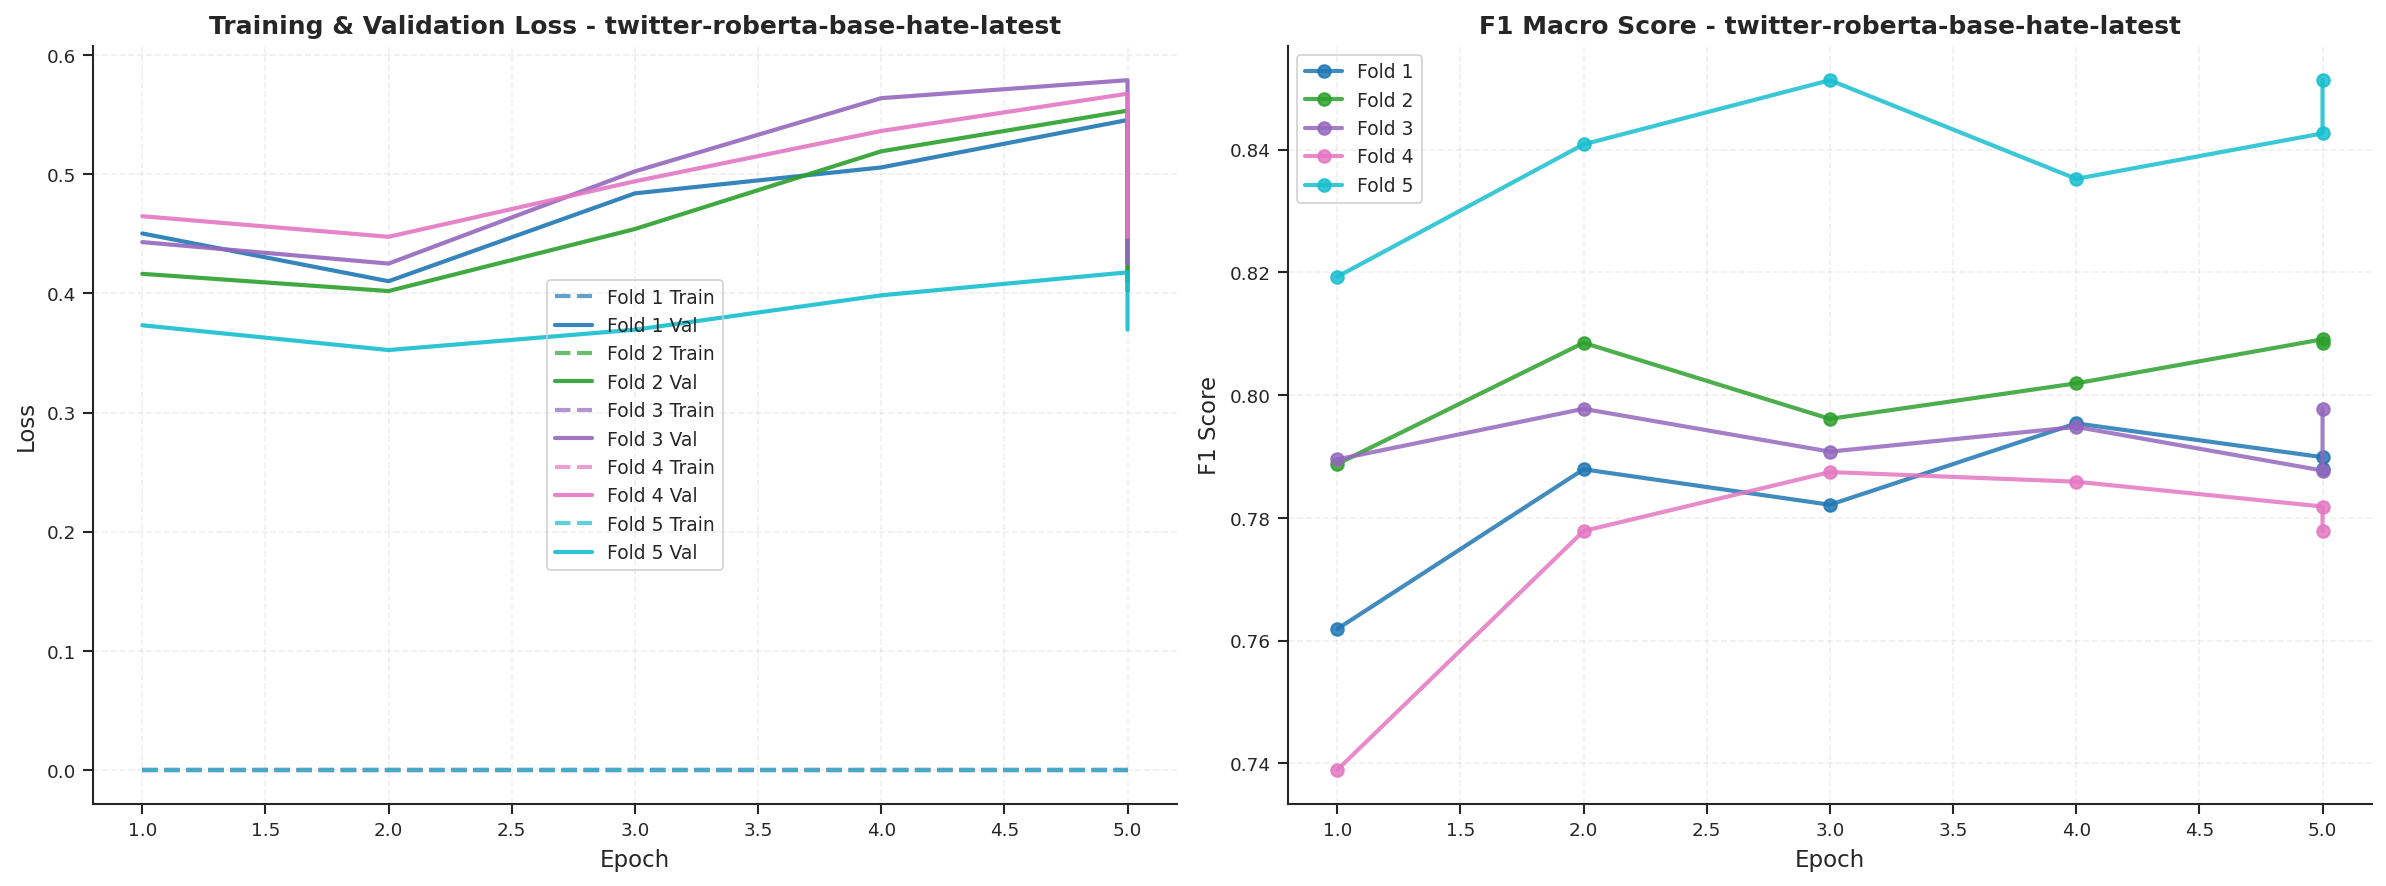


Making Weighted Ensemble Predictions

Getting predictions from Fold 1 (F1: 0.7879, Loss: 0.4103)...


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Getting predictions from Fold 2 (F1: 0.8085, Loss: 0.4020)...


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Getting predictions from Fold 3 (F1: 0.7978, Loss: 0.4251)...


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Getting predictions from Fold 4 (F1: 0.7779, Loss: 0.4476)...


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Getting predictions from Fold 5 (F1: 0.8513, Loss: 0.3696)...


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.



Ensemble weights: [0.19535899 0.20160578 0.19722297 0.19032097 0.21549129]

✓ Saved predictions to subtask_1/pred_eng.csv

Sample predictions:
                                     id  polarization
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0
2  eng_95770ff547ea5e48b0be00f385986483             0
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             1
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0
5  eng_153d96f9dc27f0602c927223404d94b5             0
6  eng_4ab5a4cc5c87d0af9cf4b80c301647bf             0
7  eng_e75a95ba52930d6d72d503ab9469eb29             0
8  eng_eb8fab668668f9959cafdecbfc0f081a             0
9  eng_702724dc168d600e788d775c8e651f36             0

Prediction distribution:
polarization
0    103
1     57
Name: count, dtype: int64

Saving Fold Models

✓ Created compressed file: subtask_1_eng_ensemble.zip


In [ ]:
# Runing ensemble
# Example 1: Train new model
# if __name__ == "__main__":
#     main()

# Example 2: Load saved model and make predictions
# if __name__ == "__main__":
#     predictions = predict_with_saved_model(
#         test_csv_path='subtask1/dev/eng.csv',
#         language='english',
#         output_csv='new_predictions.csv'
#     )

# Example 3: Continue training a saved model
# if __name__ == "__main__":
#     trainer = continue_training(
#         train_csv_path='subtask1/train/eng.csv',
#         language='english',
#         additional_epochs=5
#     )

# Example 4: Load model for custom use
# if __name__ == "__main__":
#     model, tokenizer = load_saved_model('english')
#     # Use model and tokenizer for your custom tasks
#     print(f"Model loaded: {model}")
#     print(f"Tokenizer loaded: {tokenizer}")

# Run main training pipeline
# if __name__ == "__main__":
#     main()
if __name__ == "__main__":
    main()

## Task 2


In [ ]:
train = pd.read_csv('subtask2/train/eng.csv')
test = pd.read_csv('subtask2/dev/eng.csv')
# fix this for this subtask
train.head()
train['stratify_key'] = train[['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']].apply(
    lambda row: '_'.join(row.astype(str)), axis=1
)

train, val = train_test_split(
    train,
    test_size=0.2
)

train.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other,stratify_key
1253,eng_57aa74792bbbc1336967c75b0b5a3112,What Joe Bidens negative poll numbers say his re,0,0,0,0,0,0_0_0_0_0
2330,eng_5f094ca7090a638fcb7580242a7124f1,youtu.bed905WU2L1no?... Apartheid Ethnic Clean...,1,1,1,0,0,0_1_1_1_0
2773,eng_fb49623d6d9744eb694f70b65915e2ca,FT Trump intends to continue US military aid t...,0,0,0,0,0,0_0_0_0_0
190,eng_70b07c68544e8a050df849a6fff6b13d,CBS News U.S. has intel that Russian commander...,0,0,0,0,0,0_0_0_0_0
215,eng_eec1d2b096a2980efe601b6d21c4b9c1,"continued military aid to Ukraine, and controv...",0,0,0,0,0,0_0_0_0_0


In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item
class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base
# Create train and Test dataset for multilabel

train_dataset = PolarizationDataset(train['text'].tolist(), train[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
test_dataset = PolarizationDataset(test['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
# dev_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base', num_labels=5, problem_type="multi_label_classification",ignore_mismatched_sizes=True) # 5 labels

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
label_cols = ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']
# FacebookAI/xlm-roberta-base
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
train_dataset = PolarizationDataset(
    train['text'].tolist(),
    train[label_cols].values.tolist(),
    tokenizer
)

val_dataset = PolarizationDataset(
    val['text'].tolist(),
    val[label_cols].values.tolist(),
    tokenizer
)

test_dataset = PolarizationTestDataset(
    test['text'].tolist(),
    tokenizer
)


In [ ]:
def compute_class_weights(labels_array):
    """Compute weights for each class based on frequency"""
    pos_counts = labels_array.sum(axis=0)
    neg_counts = len(labels_array) - pos_counts
    weights = neg_counts / (pos_counts + 1e-5)  # Avoid division by zero
    return torch.FloatTensor(weights)

class_weights = compute_class_weights(train[label_cols].values)
print(f"\nClass weights: {class_weights.numpy()}")

# Custom Trainer with weighted loss
class WeightedBCETrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted BCE loss
        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
        else:
            loss_fct = torch.nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Improved metrics with optimal threshold search
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions)).numpy()
    labels = p.label_ids

    # Try multiple thresholds and pick the best
    best_f1 = 0
    best_threshold = 0.5

    for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
        preds = (probs > threshold).astype(int)
        f1 = f1_score(labels, preds, average='macro', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Use best threshold
    preds = (probs > best_threshold).astype(int)

    # Per-class F1 scores
    per_class_f1 = f1_score(labels, preds, average=None, zero_division=0)

    metrics = {
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'f1_micro': f1_score(labels, preds, average='micro', zero_division=0),
        'f1_weighted': f1_score(labels, preds, average='weighted', zero_division=0),
        'best_threshold': best_threshold
    }

    # Add per-class metrics
    label_names = ['gender_sexual', 'political', 'religious', 'racial_ethnic', 'other']
    for i, name in enumerate(label_names):
        metrics[f'f1_{name}'] = per_class_f1[i]

    return metrics

# Optimized training arguments
training_args = TrainingArguments(
    output_dir="/content/outputs/",

    # Training schedule
    num_train_epochs=5,
    learning_rate=3e-5,  # Slightly higher for faster convergence
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    # Batch sizes
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # Regularization
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    save_total_limit=3,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Performance
    fp16=True,
    dataloader_num_workers=2,

    # Other
    seed=42,
    report_to="none"
)


Class weights: [43.431026   1.8443708 26.709675  11.509708  25.295916 ]


In [ ]:
# Initialize trainer with class weights
trainer = WeightedBCETrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

# Train
print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

trainer.train()

log_history = trainer.state.log_history
# Evaluate on validation set
print("\n" + "="*50)
print("Validation Results:")
print("="*50)
eval_results = trainer.evaluate()
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")




Starting training...



Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,Best Threshold,F1 Gender Sexual,F1 Political,F1 Religious,F1 Racial Ethnic,F1 Other
1,0.007600,4.031364,0.460421,0.651351,0.636884,0.700000,0.400000,0.752988,0.478261,0.528000,0.142857
2,0.060700,3.983289,0.460703,0.639697,0.629343,0.300000,0.400000,0.730337,0.440000,0.562963,0.170213
3,0.107500,3.773175,0.484559,0.639303,0.644576,0.300000,0.424242,0.751938,0.488889,0.532374,0.225352
4,0.007300,4.391540,0.462185,0.638655,0.627591,0.700000,0.434783,0.739669,0.487805,0.521008,0.127660
5,0.005500,4.361979,0.463552,0.638655,0.628460,0.700000,0.434783,0.738589,0.487805,0.528926,0.127660



Validation Results:


eval_loss: 3.7732
eval_f1_macro: 0.4846
eval_f1_micro: 0.6393
eval_f1_weighted: 0.6446
eval_best_threshold: 0.3000
eval_f1_gender_sexual: 0.4242
eval_f1_political: 0.7519
eval_f1_religious: 0.4889
eval_f1_racial_ethnic: 0.5324
eval_f1_other: 0.2254
eval_runtime: 0.8467
eval_samples_per_second: 761.7460
eval_steps_per_second: 24.8010


### old


In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"/content/outputs/",
    num_train_epochs=5,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)
# trainer = CombinedMetricTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics_multilabel,  # ← Using multi-label metrics
#     data_collator=DataCollatorWithPadding(tokenizer),
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
#     f1_weight=0.7,  # 70% focus on F1
#     loss_weight=0.3  # 30% focus on loss
# )

# Train the model
trainer.train()

log_history = trainer.state.log_history
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.216826,0.226742
2,0.197100,0.209871,0.239899
3,0.170900,0.219339,0.214812
4,0.147400,0.230323,0.250172
5,0.126500,0.237220,0.254821


Macro F1 score on validation set for Subtask 2: 0.2548208313425705


In [ ]:
import os
import zipfile
import numpy as np

predictions = trainer.predict(test_dataset)

# For multi-label classification, you need to apply sigmoid and threshold
# Assuming your model outputs logits for each label
predicted_probs = torch.sigmoid(torch.tensor(predictions.predictions))

# Apply threshold (0.5) to get binary predictions
predicted_labels = (predicted_probs > 0.5).int().numpy()

# If you have 5 labels in order: political, racial/ethnic, religious, gender/sexual, other
# Create a dataframe with all columns
results_df = pd.DataFrame({
    'id': test['id'],
    'political': predicted_labels[:, 0],
    'racial/ethnic': predicted_labels[:, 1],
    'religious': predicted_labels[:, 2],
    'gender/sexual': predicted_labels[:, 3],
    'other': predicted_labels[:, 4]
})

# Create the folder if it doesn't exist
os.makedirs('subtask_2', exist_ok=True)

# Save to CSV in the folder
csv_path = 'subtask_2/pred_eng.csv'
results_df.to_csv(csv_path, index=False)

print(f"Saved predictions to {csv_path}")
print(results_df.head())

# Compress the folder
zip_filename = 'subtask_2_eng_robertabase.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder and add all files
    for root, dirs, files in os.walk('subtask_2'):
        for file in files:
            file_path = os.path.join(root, file)
            # Add file to zip with relative path
            arcname = os.path.join(os.path.basename(root), file)
            zipf.write(file_path, arcname)

print(f"Created compressed file: {zip_filename}")

Saved predictions to subtask_2/pred_eng.csv
                                     id  political  racial/ethnic  religious  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58          0              0          0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb          0              0          0   
2  eng_95770ff547ea5e48b0be00f385986483          0              0          0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf          0              0          0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20          0              0          0   

   gender/sexual  other  
0              0      0  
1              0      0  
2              0      0  
3              0      0  
4              0      0  
Created compressed file: subtask_2_eng_robertabase.zip


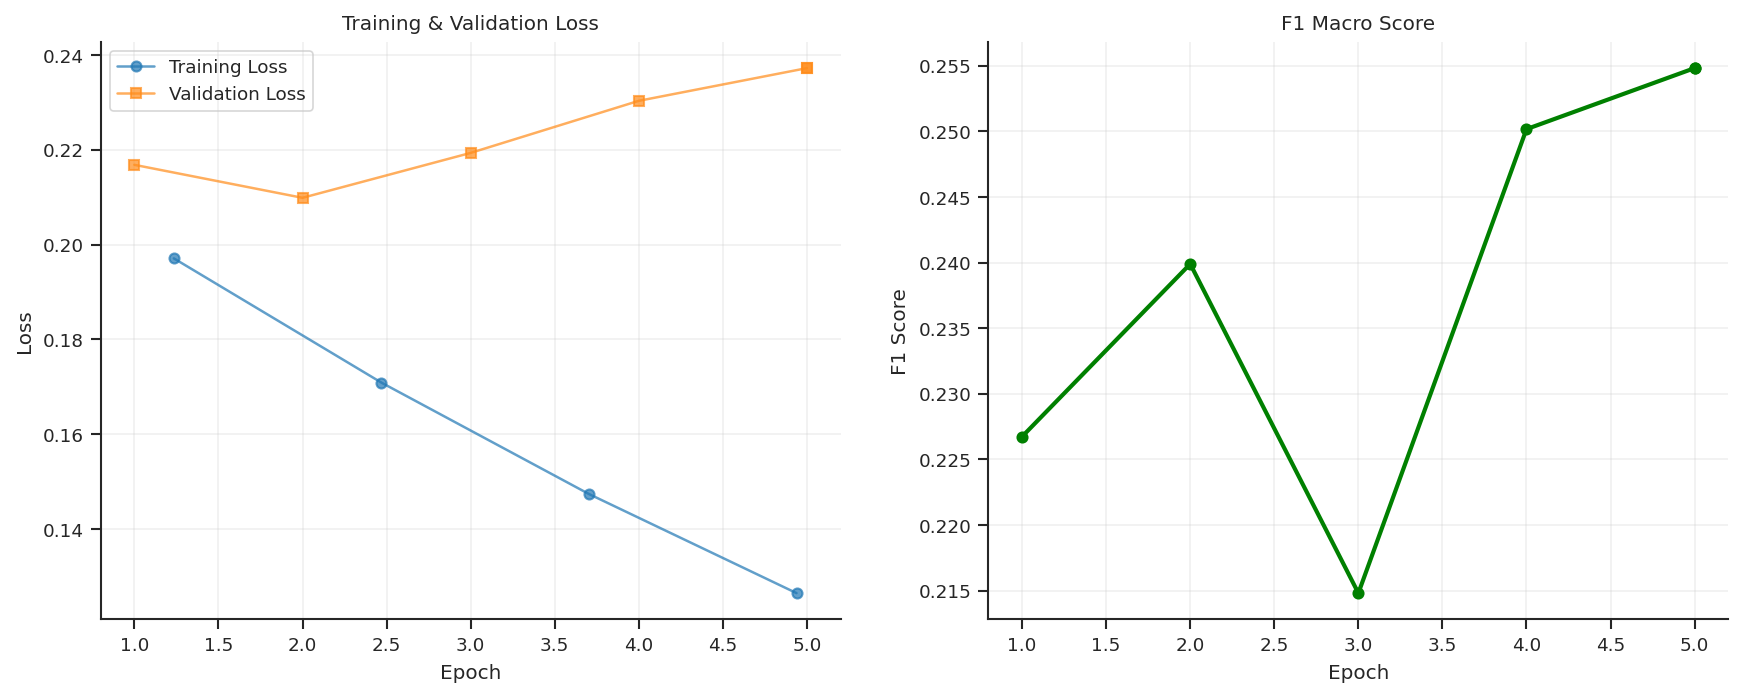

In [ ]:



# Convert to DataFrame for easier plotting
logs_df = pd.DataFrame(log_history)
# print(logs_df)

# Prepare data
train_logs = logs_df[logs_df['loss'].notna()]
eval_logs = logs_df[logs_df['eval_loss'].notna()]

# Create subplot mosaic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Both losses
axes[0].plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', marker='o', alpha=0.7)
axes[0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: F1 Score
axes[1].plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Macro Score')
axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('single_train_task2_robertabase',dpi=200,format='pdf' )
plt.show()

In [ ]:
#prediction on test
trainer.save_model('task_2_eng_cardiffhate_bigger')

## look for loading model